#### **Welcome to Assignment 2 on Deep Learning for Computer Vision.**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [ ]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image using hough transform. 

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180


Which of the following pairs of (start, end) co-ordinates of detected lines are true:

1. line-1: (1,81), (27,9) ; line-2 : (92,0), (95,64)
2. line-1: (2,79), (26,11) ; line-2 : (92,1), (94,67)
3. line-1: (2,80), (26,10) ; line-2: (91,2), (96,65)
4.  None of the above

In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()


#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)
#plt.imshow(edges)
#plt.show()

####YOUR CODE STARTS HERE #####
rho = 1
theta = np.pi/180
threshold = 15
min_line_length = 60
max_line_gap = 250
line_image = np.copy(img)*0 #creating a blank to draw lines on

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 5)
    
img_line = cv2.addWeighted(img, 0.8, line_image, 1, 0)

####YOUR CODE ENDS HERE #####
plt.imshow(img_line)
plt.title('Detected Line Image')
plt.show()

print(lines)

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

Which of the following is the estimated number of inliers for an outlier rate of 0.9:

1. 89
2. 101
3. 117
4. 132

In [ ]:
import numpy as np
np.random.seed(0)


# Affine Transform
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# pts_t =    A   * pts_s  + t

# -------------------------------------------------------------
# Test Class Affine

class Affine_Transform():

    def create_test_case(self, outlier_rate=0):
        ''' CREATE_TEST_CASE

            Randomly generate a test case of affine transformation.

            Input arguments:

            - outlier_rate : the percentage of outliers in test case,
            default is 0

            Outputs:

            - pts_s : Source points that will be transformed
            - pts_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''

        # Randomly generate affine transformation
        # A is a 2x2 matrix, the range of each value is from -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # % t is a 2x1 VECTOR, the range of each value is from -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the number of points in test case
        num = 1000

        # Compute the number of outliers and inliers respectively
        outliers = int(np.round(num * outlier_rate))
        inliers = int(num - outliers)

        # Gernerate source points whose scope from (0,0) to (100, 100)
        pts_s = 100 * np.random.rand(2, num)
        # Initialize warped points matrix
        pts_t = np.zeros((2, num))

        # Compute inliers in warped points matrix by applying A and t
        pts_t[:, :inliers] = np.dot(A, pts_s[:, :inliers]) + t

        # Generate outliers in warped points matrix
        pts_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix,
        # outliers and inliers will scatter randomly in test case
        rnd_idx = np.random.permutation(num)
        pts_s = pts_s[:, rnd_idx]
        pts_t = pts_t[:, rnd_idx]

        return A, t, pts_s, pts_t

    def estimate_affine(self, pts_s, pts_t):
        ''' ESTIMATE_AFFINE

            Estimate affine transformation by the given points
            correspondences.

            Input arguments:
            - pts_t : points in target image
            - pts_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation to compute theta by:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        # Get the number of corresponding points
        pts_num = pts_s.shape[1]

        # Initialize the matrix M,
        # M has 6 columns, since the affine transformation
        # has 6 parameters in this case
        M = np.zeros((2 * pts_num, 6))

        for i in range(pts_num):
            # Form the matrix m
            temp = [[pts_s[0, i], pts_s[1, i], 0, 0, 1, 0],
                    [0, 0, pts_s[0, i], pts_s[1, i], 0, 1]]
            M[2 * i: 2 * i + 2, :] = np.array(temp)

        # Form the matrix b,
        # b contains all known target points
        b = pts_t.T.reshape((2 * pts_num, 1))

        try:
            # Solve the linear equation
            theta = np.linalg.lstsq(M, b)[0]

            # Form the affine transformation
            A = theta[:4].reshape((2, 2))
            t = theta[4:]
        except np.linalg.linalg.LinAlgError:
            # If M is singular matrix, return None
            # print("Singular matrix.")
            A = None
            t = None

        return A, t
# -------------------------------------------------------------

# Create instance
af = Affine_Transform()

# Generate a test case as validation with
# a rate of outliers
outlier_rate = 0.90
A_true, t_true, pts_s, pts_t = af.create_test_case(outlier_rate)

# At least 3 corresponding points to
# estimate affine transformation
K = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, pts_s.shape[1], (K, 1))

A_test, t_test = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])

# Display known parameters with estimations
# They should be same when outlier_rate equals to 0,
# otherwise, they are totally different in some cases
#print(A_true, '\n', t_true)
#print(A_test, '\n', t_test)

# -------------------------------------------------------------
# Test Class Ransac
# The number of iterations in RANSAC
ITER_NUM = 2000


class Ransac():

    def __init__(self, K=3, threshold=1):
        ''' __INIT__

            Initialize the instance.

            Input argements:

            - K : the number of corresponding points,
            default is 3
            - threshold : determing which points are inliers
            by comparing residual with it

        '''

        self.K = K
        self.threshold = threshold

    def residual_lengths(self, A, t, pts_s, pts_t):
        ''' RESIDUAL_LENGTHS

            Compute residual length (Euclidean distance) between
            estimation and real target points. Estimation are
            calculated by the given source point and affine
            transformation (A & t).

            Input arguments:

            - A, t : the estimated affine transformation calculated
            by least squares method
            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - residual : Euclidean distance between estimated points
            and real target points

        '''

        if not(A is None) and not(t is None):
            # Calculate estimated points:
            # pts_e = A * pts_s + t
            pts_e = np.dot(A, pts_s) + t

            # Calculate the residual length between estimated points
            # and target points
            diff_square = np.power(pts_e - pts_t, 2)
            residual = np.sqrt(np.sum(diff_square, axis=0))
        else:
            residual = None

        return residual

    def ransac_fit(self, pts_s, pts_t):
        ''' RANSAC_FIT

            Apply the method of RANSAC to obtain the estimation of
            affine transformation and inliers as well.

            Input arguments:

            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers that will be applied to refine the
            affine transformation

        '''
        #### YOUR CODE START HERE


        
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = Ransac(K=3, threshold=1)

residual = rs.residual_lengths(A_test, t_test, pts_s, pts_t)

# Run RANSAC to estimate affine transformation when
# too many outliers in points set
A_rsc, t_rsc, inliers = rs.ransac_fit(pts_s, pts_t)

# print the number of inliners or point matches
print (inliers[0].shape)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?

1.   169
2.   222
3.   264
4.   309


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

## STEP 2: Detect corners 
dst = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
#img[dst>0.01*dst.max()]=[0,0,255]

## STEP 5: Count numer of detected corner points and draw them on the image
s=0
for i in range(dst.shape[0]):
    for j in range(dst.shape[1]):
        if dst[i,j]>0.1*dst.max():
            s+=1
print(s)

### YOUR CODE ENDS HERE

# Part-2

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [156]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda")
print(device)
print(torch.__version__)
#### YOUR CODE ENDS HERE ####

# define a transforms for preparing the dataset
transform = transforms.Compose([
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.1307,), (0.3081,)) # normalise the images with mean and std of the dataset
        ])

cuda
1.6.0


tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

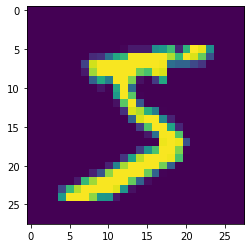

In [157]:
import torchvision
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = torchvision.datasets.MNIST(root = "./data", train = True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root = "./data", train = False, download=True, transform=transform)

print(train_dataset[0][0])
img = train_dataset[0][0].permute(1,2,0)
plt.imshow(img)
# print(len(train_dataset))
# print(print(train_dataset[0][1]))
# print(len(test_dataset))
# print(train_dataset[0][0].size())
#### YOUR CODE ENDS HERE ####

In [4]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
#### YOUR CODE ENDS HERE ####

*italicised text*### Network Definition

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11, out_features=128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        self.act = nn.ReLU()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        #### YOUR CODE STARTS HERE ####
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = x.reshape(x.size(0), -1)
        #print(x.size())
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(x, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [6]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 1.025s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        print(data.shape)
        target = target.to(device)
        print(target.shape)
        # flush out the gradients stored in optimizer
        model.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = nn.NLLLoss()(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += nn.NLLLoss()(output, target).item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Run the code cell below and report the final test accuracy (If you are not getting the exact number shown in options, please report the closest number).
1. 64%
2. 79%
3. 97%
4. 90%

In [9]:
model = Net().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-2.2221, -2.2875, -2.2592, -2.2738, -2.3402, -2.4100, -2.3301, -2.3441,
         -2.3047, -2.2671],
        [-2.2222, -2.3178, -2.2816, -2.2409, -2.3849, -2.3735, -2.3406, -2.3254,
         -2.2722, -2.2797],
        [-2.1603, -2.2942, -2.3372, -2.2825, -2.3504, -2.4483, -2.3326, -2.3161,
         -2.2713, -2.2578],
        [-2.2503, -2.3455, -2.3041, -2.2419, -2.3134, -2.4337, -2.3892, -2.1925,
         -2.3325, -2.2471],
        [-2.1580, -2.2624, -2.3663, -2.2942, -2.3584, -2.4086, -2.3193, -2.3010,
         -2.3139, -2.2655],
        [-2.2601, -2.2725, -2.2946, -2.3036, -2.3302, -2.3920, -2.3292, -2.3225,
         -2.2590, -2.2699],
        [-2.1936, -2.2777, -2.3148, -2.2857, -2.3320, -2.4226, -2.3082, -2.2951,
         -2.3453, -2.2665],
        [-2.2770, -2.2606, -2.3157, -2.2844, -2.3746, -2.3600, -2.3131, -2.3422,
         -2.2792, -2.2287],
        [-2.2353, -2.2527, -2.3180, -2.2540, -2.3503, -2.3873, -2.3013, -2.3130,
  

         -2.2308, -1.1725]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[ -5.4661,  -2.7836,  -4.9755,  -2.5273,  -1.3811,  -3.4452,  -4.9701,
          -2.1290,  -1.2002,  -1.9883],
        [ -6.8853,  -1.9704,  -4.2267,  -4.2292,  -1.7935,  -2.5007,  -1.5242,
          -2.1063,  -1.6437,  -3.0103],
        [ -6.8496,  -2.2223,  -4.6197,  -0.4357,  -4.3874,  -2.5187,  -4.5689,
          -3.7784,  -2.2950,  -4.9718],
        [ -5.6189,  -2.3763,  -3.2947,  -2.0602,  -0.9687,  -4.0866,  -4.2214,
          -1.6094,  -3.1218,  -2.4789],
        [ -0.4723,  -5.4154,  -5.2059,  -2.0027,  -2.9596,  -2.2030,  -4.6605,
          -4.7732,  -3.1110,  -4.9941],
        [ -6.2621,  -2.0141,  -1.2454,  -1.4129,  -2.8227,  -4.2673,  -5.3477,
          -4.5554,  -1.4205,  -5.7925],
        [ -0.5396,  -4.2610,  -5.0796,  -2.1125,  -3.0569,  -2.1746,  -5.8133,
          -5.1162,  -2.2667,  -6.0229],
        [ -3.4272,  -2.6421,  -2.9970,  -2.325

       grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-8.8028e+00, -7.1800e+00, -7.0601e+00, -3.0321e+00, -8.8055e+00,
         -3.8717e-01, -1.0461e+01, -8.3368e+00, -1.3077e+00, -8.6673e+00],
        [-1.0247e+01, -8.5799e-02, -5.9709e+00, -5.4552e+00, -7.2171e+00,
         -5.7245e+00, -7.0187e+00, -3.3124e+00, -3.8260e+00, -4.4031e+00],
        [-6.6702e+00, -4.4841e+00, -2.5153e+00, -4.2069e+00, -6.2498e+00,
         -6.1562e+00, -1.7625e-01, -8.1792e+00, -3.0218e+00, -8.2575e+00],
        [-1.4426e+01, -4.5287e+00, -2.4309e-02, -4.7816e+00, -1.0538e+01,
         -1.1184e+01, -5.8084e+00, -9.3435e+00, -6.4068e+00, -9.7541e+00],
        [-5.6007e+00, -3.4032e+00, -2.4257e+00, -3.3307e+00, -4.7229e+00,
         -4.3189e+00, -2.1853e-01, -6.8639e+00, -4.5005e+00, -7.1322e+00],
        [-5.0934e+00, -2.3033e+00, -1.7217e+00, -2.5880e+00, -3.7946e+00,
         -4.2760e+00, -6.9590e-01, -4.5565e+00, -2.6350e+00, -3.7826e+00],
        [-6.8466e+00, -1

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-2.0280e+00, -1.3260e+01, -1.2306e+00, -3.2844e+00, -6.8165e+00,
         -1.6235e+00, -5.3464e+00, -9.7862e+00, -1.1066e+00, -5.2954e+00],
        [-3.1428e-02, -1.8350e+01, -1.1928e+01, -7.5948e+00, -1.0950e+01,
         -3.5314e+00, -7.7767e+00, -9.3836e+00, -7.4088e+00, -1.0160e+01],
        [-4.5004e+00, -9.7462e+00, -3.0358e+00, -3.3289e+00, -4.8298e+00,
         -2.7971e+00, -3.8988e+00, -9.9253e+00, -2.0491e-01, -6.9471e+00],
        [-1.7296e+00, -1.4096e+01, -3.1707e-01, -2.8187e+00, -1.1534e+01,
         -4.4008e+00, -9.2429e+00, -1.2020e+01, -3.8077e+00, -9.1577e+00],
        [-9.1903e+00, -1.5532e+01, -1.0955e+01, -1.3338e+01, -5.2207e+00,
         -7.0923e+00, -1.0175e+01, -9.3610e+00, -1.2144e-02, -5.1867e+00],
        [-1.4042e+01, -1.6253e+01, -1.8254e+01, -1.4491e+01, -1.2328e+01,
         -1.4696e+01, -2.0295e+01, -7.6139e-03, -1.5238e+01, -4.8824e+00],
       

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-1.1809e+01, -3.9810e-01, -2.3486e+00, -3.9010e+00, -5.6783e+00,
         -6.6373e+00, -7.5533e+00, -2.6179e+00, -2.1521e+00, -4.0052e+00],
        [-1.3868e-01, -1.3831e+01, -3.6779e+00, -2.3230e+00, -1.0935e+01,
         -5.2260e+00, -8.4366e+00, -9.1429e+00, -7.9953e+00, -8.5972e+00],
        [-1.3952e+01, -1.0333e+01, -4.6225e+00, -6.4524e+00, -1.9743e-02,
         -1.0177e+01, -6.4350e+00, -6.8133e+00, -9.3617e+00, -5.2432e+00],
        [-9.8607e+00, -1.0043e+01, -7.3451e+00, -1.6702e+00, -3.7421e+00,
         -2.9608e+00, -1.0330e+01, -1.2225e+00, -5.7430e+00, -8.2594e-01],
        [-1.4529e+01, -1.0700e+01, -1.0134e+01, -2.6442e+00, -1.1321e-01,
         -3.9492e+00, -1.1426e+01, -6.4577e+00, -8.2972e+00, -4.2124e+00],
        [-7.8114e+00, -3.8879e+00, -3.6523e+00, -3.3612e+00, -3.6441e+00,
         -3.2983e+00, -6.6665e+00, -3.2963e+00, -2.3342e-01, -3.6779e+00],
       

Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.472681
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-1.1831e+01, -9.1012e-03, -9.3692e+00, -1.1501e+01, -8.6218e+00,
         -1.1410e+01, -1.0440e+01, -4.7604e+00, -8.7854e+00, -1.0745e+01],
        [-7.7977e+00, -7.5471e+00, -6.9782e+00, -6.5761e+00, -5.1252e+00,
         -5.4607e+00, -8.1877e+00, -3.7221e+00, -5.8365e-02, -3.9753e+00],
        [-1.3933e+01, -7.7937e+00, -9.8774e+00, -8.9657e+00, -7.0810e+00,
         -1.0009e+01, -1.2259e+01, -1.0071e-01, -4.8172e+00, -2.4507e+00],
        [-1.0430e+01, -2.1087e+01, -1.4984e+01, -7.5218e+00, -1.2496e+01,
         -1.2702e-02, -1.6346e+01, -1.2187e+01, -4.4271e+00, -9.2954e+00],
        [-7.0061e+00, -8.1848e+00, -1.2841e-01, -4.4234e+00, -6.1125e+00,
         -8.2612e+00, -3.3369e+00, -6.0894e+00, -3.5041e+00, -3.2977e+00],
        [-1.1579e+01, -4.8945e+00, -8.2096e-01, -6.0949e+00, -5.4954e+00,
         -1.2154e+01, -6.1951e+00, -6.2460e-01, -5.8526e+00, -5.1606e+00],
        [-1.7

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-1.1184e+01, -1.2495e+01, -7.9946e+00, -1.2213e+01, -8.0066e+00,
         -1.2965e+01, -7.1905e-04, -1.2615e+01, -1.1522e+01, -1.1492e+01],
        [-6.1602e+00, -1.6757e+01, -1.0363e+01, -5.3345e+00, -9.2783e+00,
         -5.0515e+00, -1.6863e+01, -1.4246e-01, -6.8814e+00, -2.1346e+00],
        [-1.6505e+01, -8.7352e+00, -1.5020e+00, -2.6360e-01, -1.5581e+01,
         -9.6377e+00, -4.8417e+00, -1.5048e+01, -6.9896e+00, -1.7139e+01],
        [-9.8376e+00, -8.2368e+00, -3.2169e+00, -5.3221e+00, -9.1329e-01,
         -8.0364e+00, -5.9761e-01, -9.1367e+00, -5.9995e+00, -7.6353e+00],
        [-9.7645e+00, -1.2497e+01, -4.0610e+00, -7.8119e+00, -8.4094e+00,
         -9.3614e+00, -1.8329e-02, -1.2957e+01, -8.9679e+00, -1.0559e+01],
        [-9.1999e+00, -1.5161e+01, -1.2831e+01, -9.3239e+00, -9.8325e+00,
         -2.1928e-02, -9.2628e+00, -1.2181e+01, -4.1649e+00, -5.1479e+00],
       

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-7.0961e+00, -3.6376e+00, -4.3332e+00, -5.9836e+00, -1.9987e-01,
         -5.7773e+00, -2.4021e+00, -5.5766e+00, -3.9071e+00, -3.8697e+00],
        [-1.0176e+01, -4.8386e-02, -7.4641e+00, -6.6096e+00, -5.3065e+00,
         -7.5647e+00, -5.0821e+00, -7.4043e+00, -3.4400e+00, -6.9943e+00],
        [-4.8547e+00, -7.8152e+00, -4.9002e+00, -4.3945e+00, -4.3915e+00,
         -2.6513e+00, -4.8405e+00, -4.4360e+00, -4.7250e-01, -1.4029e+00],
        [-1.0341e+01, -7.3917e+00, -5.6179e+00, -5.5123e+00, -6.0333e+00,
         -9.0572e+00, -1.0211e+01, -1.3210e-01, -7.2166e+00, -2.1880e+00],
        [-5.0204e+00, -1.0606e+01, -8.1297e+00, -5.8338e+00, -1.0836e+01,
         -1.0045e+01, -1.2813e+01, -1.2594e-02, -9.0379e+00, -5.9985e+00],
        [-5.2119e+00, -6.0961e+00, -4.3452e+00, -3.5001e+00, -9.2597e-01,
         -3.9240e+00, -5.5102e+00, -2.5719e+00, -4.3463e+00, -8.2136e-01],
       

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-1.3222e+01, -1.2121e+01, -7.0261e-04, -8.7380e+00, -8.7430e+00,
         -1.3874e+01, -1.0850e+01, -9.0536e+00, -8.8777e+00, -9.2262e+00],
        [-1.3193e+01, -7.7194e+00, -8.3124e+00, -4.8263e-01, -6.3423e+00,
         -1.1761e+00, -6.1715e+00, -1.0422e+01, -2.6811e+00, -6.6369e+00],
        [-4.6380e+00, -2.7625e+00, -3.8929e+00, -5.7700e+00, -4.0926e+00,
         -2.3350e+00, -2.6217e+00, -5.1732e+00, -3.7871e-01, -3.6084e+00],
        [-5.4863e+00, -1.0205e+01, -8.4095e+00, -1.3490e+01, -7.1033e+00,
         -4.3113e+00, -1.9495e-02, -8.8891e+00, -7.7590e+00, -9.2270e+00],
        [-1.2288e+01, -1.4099e-02, -7.9705e+00, -8.5813e+00, -5.3187e+00,
         -7.0993e+00, -7.0200e+00, -6.4130e+00, -5.3518e+00, -7.6761e+00],
        [-1.7295e+01, -1.4594e+01, -2.2542e-03, -6.0978e+00, -1.9966e+01,
         -2.1095e+01, -1.9592e+01, -1.2686e+01, -1.4845e+01, -1.7040e+01],
       

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-7.2264e-01, -1.0738e+01, -7.8787e-01, -2.9995e+00, -1.5954e+01,
         -8.5001e+00, -4.8855e+00, -9.6068e+00, -6.2311e+00, -9.2771e+00],
        [-4.4671e+00, -4.5122e+00, -6.4949e+00, -7.4548e+00, -9.9147e+00,
         -3.5566e+00, -6.0147e+00, -8.6420e+00, -5.7770e-02, -7.8636e+00],
        [-5.5887e+00, -5.0227e+00, -3.2363e+00, -5.6531e+00, -5.4140e+00,
         -4.7372e+00, -9.8334e-02, -6.6029e+00, -3.9400e+00, -5.0376e+00],
        [-1.3518e+01, -1.5743e+01, -1.6371e+01, -6.1652e+00, -1.5094e+01,
         -3.4441e-03, -1.1058e+01, -1.4806e+01, -6.7976e+00, -8.5052e+00],
        [-9.7965e+00, -8.3832e+00, -7.3775e+00, -1.6308e-02, -1.3002e+01,
         -4.2614e+00, -7.3840e+00, -9.7272e+00, -7.6703e+00, -1.1143e+01],
        [-1.0522e+01, -1.3524e+01, -8.4409e+00, -1.9703e-03, -1.5579e+01,
         -6.7415e+00, -1.3837e+01, -1.2758e+01, -7.5798e+00, -1.0464e+01],
       

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-8.7071e+00, -6.4863e-02, -3.9550e+00, -5.4021e+00, -4.6855e+00,
         -7.1642e+00, -5.5824e+00, -6.3981e+00, -3.7953e+00, -6.8424e+00],
        [-1.2778e-02, -1.4119e+01, -8.8990e+00, -8.7493e+00, -1.2538e+01,
         -5.8234e+00, -4.8884e+00, -7.1796e+00, -7.2963e+00, -7.6710e+00],
        [-2.4435e-04, -1.9506e+01, -1.1041e+01, -1.0737e+01, -1.9513e+01,
         -1.0065e+01, -8.7942e+00, -1.2396e+01, -1.2125e+01, -1.2745e+01],
        [-5.0577e+00, -8.9362e+00, -5.0030e+00, -6.2305e+00, -7.7395e+00,
         -6.5657e+00, -1.8832e-02, -9.2852e+00, -7.7932e+00, -6.7869e+00],
        [-2.9031e-01, -1.1687e+01, -1.9747e+00, -2.3308e+00, -1.2534e+01,
         -6.1701e+00, -6.9032e+00, -6.7534e+00, -7.2453e+00, -4.5134e+00],
        [-8.1947e+00, -8.9075e+00, -6.7809e+00, -8.9605e+00, -6.0537e-03,
         -7.6640e+00, -7.8562e+00, -7.3896e+00, -8.1695e+00, -5.9512e+00],
       

       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-1.6866e-02, -1.8069e+01, -9.0671e+00, -1.3529e+01, -1.0444e+01,
         -8.2669e+00, -5.3425e+00, -9.9770e+00, -4.5227e+00, -7.3679e+00],
        [-5.0815e+00, -8.5720e+00, -6.5016e+00, -4.1293e+00, -4.5602e+00,
         -2.6599e-01, -2.0317e+00, -7.4401e+00, -5.2388e+00, -2.7791e+00],
        [-8.5982e+00, -1.4619e+01, -1.0052e+01, -8.8946e+00, -4.7362e+00,
         -9.5742e+00, -1.0969e+01, -4.0825e+00, -3.5545e+00, -5.6236e-02],
        [-1.7378e+01, -1.2030e+01, -1.4232e+01, -1.6876e+01, -1.1325e-05,
         -1.6616e+01, -1.2793e+01, -1.4996e+01, -1.6913e+01, -1.3520e+01],
        [-1.7311e+01, -9.6178e+00, -4.3805e+00, -1.4563e-02, -1.3552e+01,
         -1.1400e+01, -1.8791e+01, -6.6310e+00, -7.6441e+00, -9.7053e+00],
        [-1.4501e+01, -1.4088e+01, -3.8771e-04, -1.0346e+01, -2.0217e+01,
         -1.7144e+01, -1.9947e+01, -1.0908e+01, -8.0028e+00, -1.3447e+01],
       

torch.Size([32])
tensor([[-6.2126e+00, -8.1876e+00, -7.3701e+00, -5.5279e+00, -3.2538e-01,
         -6.3410e+00, -7.8057e+00, -4.6446e+00, -5.1978e+00, -1.3722e+00],
        [-5.7720e+00, -6.2877e+00, -5.4042e+00, -2.1713e+00, -3.7563e+00,
         -1.7330e+00, -5.9300e+00, -2.1284e+00, -4.1912e+00, -6.1700e-01],
        [-8.3246e+00, -7.5471e+00, -1.5876e+00, -2.5903e-01, -1.1396e+01,
         -5.5971e+00, -1.0581e+01, -5.8533e+00, -4.1710e+00, -6.9525e+00],
        [-6.1726e+00, -9.9576e+00, -8.2760e+00, -1.1445e+01, -7.5289e+00,
         -9.9405e+00, -3.6142e-03, -1.1520e+01, -7.4623e+00, -1.0139e+01],
        [-6.0739e+00, -5.4087e+00, -5.3435e+00, -3.1846e+00, -2.7198e+00,
         -3.6986e+00, -4.5237e+00, -3.1960e+00, -4.0576e+00, -2.3911e-01],
        [-2.2860e-01, -1.3150e+01, -4.7659e+00, -2.6491e+00, -1.2026e+01,
         -2.3258e+00, -8.0046e+00, -5.7640e+00, -4.1757e+00, -4.7588e+00],
        [-7.0387e+00, -7.6839e+00, -8.1438e+00, -3.1246e+00, -5.9941e+00,
         -9.617

torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([[-1.7814e-01, -1.0005e+01, -2.9502e+00, -6.2044e+00, -1.1113e+01,
         -2.8647e+00, -7.4672e+00, -5.5484e+00, -3.1766e+00, -5.1889e+00],
        [-6.8862e+00, -8.9912e+00, -5.3964e+00, -7.0627e+00, -7.3880e+00,
         -4.5918e+00, -8.3389e+00, -5.2998e+00, -8.1548e-02, -2.8861e+00],
        [-1.6702e+01, -1.9986e+01, -1.3996e+01, -1.0913e+01, -1.2149e+01,
         -8.8348e+00, -1.8786e+01, -5.8214e+00, -1.0106e+01, -3.1794e-03],
        [-1.2831e+01, -1.1542e-03, -1.2188e+01, -1.4632e+01, -1.6754e+01,
         -1.3976e+01, -1.0239e+01, -1.6124e+01, -6.8048e+00, -1.6297e+01],
        [-1.7853e+00, -1.3623e+01, -5.3136e+00, -1.2746e+01, -1.1168e+01,
         -9.6436e+00, -1.9020e-01, -9.7333e+00, -8.1102e+00, -9.2014e+00],
        [-3.3741e-03, -1.5484e+01, -8.0688e+00, -1.3689e+01, -1.3293e+01,
         -7.0692e+00, -6.7677e+00, -1.0645e+01, -7.3447e+00, -7.8719e+00],
        [-3.0967e+00, -7.8514e+00, -2.4780e+00, -3.2667e+00, 

KeyboardInterrupt: 

### Question 5

Modify the network to replace ReLU activations with Sigmoid and report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 

1. 95%
2. 54%
3. 20%
4. 9%

In [ ]:
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11, out_features=128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        self.act = nn.Sigmoid()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        #### YOUR CODE STARTS HERE ####
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = x.reshape(x.size(0), -1)
        #print(x.size())
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
model = NetSigmoid().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

start = timeit.default_timer()

for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

### Question 6

Train the network defined in Question-1 with Adagrad optimizer (with the same learning rate). Report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 

1. 80%
2. 99%
3. 92%
4. 85%

In [ ]:
model = Net().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.01)

start = timeit.default_timer()

for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 

1. 11%
2. 18%
3. 97%
4. 6%

In [ ]:
model = Net().to(device)

def init_weights(m):
  #### YOUR CODE STARTS HERE ####
  if isinstance(m, nn.Conv2d):
        nn.init.ones_(m.weight.data)
        nn.init.ones_(m.bias.data)
  #### YOUR CODE ENDS HERE ####
  

model.apply(init_weights)  
## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 5):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 


1. 88%
2. 74%
3. 97%
4. 80%

In [ ]:
model = Net().to(device)

def init_weights(m):
  #### YOUR CODE STARTS HERE ####
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data)
    nn.init.zeros_(m.bias.data)
  #### YOUR CODE ENDS HERE #### 

model.apply(init_weights)  
## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 5):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy by running the cell below. 

1. 92%
2. 89%
3. 98%
4. 74%

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        # define a batchnorm layer (2d) with 16 features
        self.norm1 = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16,32,3, stride=1)
        # define a batchnorm layer (2d) with 32 features
        self.norm2 = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32,64,3, stride = 1)
        # define a batchnorm layer (2d) with 64 features
        self.norm3 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        self.act = nn.ReLU()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = self.act(self.norm1(x))
        x = self.conv2(x)
        x = self.act(self.norm2(x))
        x = self.conv3(x)
        x = self.act(self.norm3(x))
        x = self.maxpool(x)
        x = self.drop1(x)
        x = self.drop2(x)
        x = x.reshape(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
model = NetBatchNorm().to(device)
# If you implemented the batchnorm layers correctly below line should return true
sum(p.numel() for p in model.parameters()) == 1016170

In [ ]:
## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

# Part-3

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.


(73257, 1)
73257


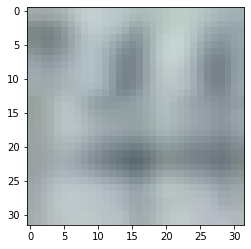

In [45]:
import scipy.io
import matplotlib.pyplot as plt

train_file = "C:/Users/manas/Downloads/train_32x32"
train_data = scipy.io.loadmat(train_file)
X_data = train_data['X']
y_data = train_data['y'] #done with importing the training data 


plt.imshow(X_data[:,:,:,15]) 
print(y_data.shape)
print(X_data.shape[3])

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [42]:
device = torch.device("cuda")
print(device)

cuda


In [43]:
class SVHNDataset(Dataset):
    
    def __init__(self, train_file):
        """
        Args:
            train_file (string): Path to the training file with the labels
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.train_data = scipy.io.loadmat(train_file)
        self.X_data = self.train_data["X"] # slicing the 4D matrix that contains data (H,W,C,B)
        self.y_data = self.train_data["y"] # slicing the labels 
        
    def __len__(self):
        return self.X_data.shape[3] #length of the training set

    def __getitem__(self, id):

        if torch.is_tensor(id):
            id = id.tolist()

        # a sample of the dataset will contain the image and the label as a tuple

        image = self.X_data[:,:,:, id]
        label = self.y_data[id]

        return (image, label)
        

(32, 32, 3)
2
The label is [2]


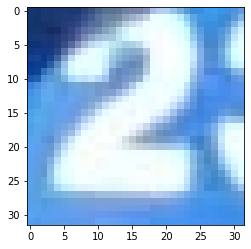

In [46]:
svhn_dataset = SVHNDataset(train_file = "C:/Users/manas/Downloads/train_32x32")

fig = plt.figure()

image = svhn_dataset[2][0] # getting the second image from the dataset

plt.imshow(image) #plotting the image 
print(image.shape)
print(svhn_dataset[2][1][0])

print("The label is {}".format(svhn_dataset[2][1])) #printing the label

In [129]:
import numpy

def compute_mean_std(svhn_dataset):
    """compute the mean and std of svhn dataset
    Args:
        svhn_training_dataset or cifar100_test_dataset
        witch derived from class torch.utils.data
    
    Returns:
        a tuple contains mean, std value of entire dataset
    """

    data_r = numpy.dstack([svhn_dataset[i][0][0, :, :] for i in range(len(svhn_dataset))])
    data_g = numpy.dstack([svhn_dataset[i][0][1, :, :] for i in range(len(svhn_dataset))])
    data_b = numpy.dstack([svhn_dataset[i][0][2, :, :] for i in range(len(svhn_dataset))])
    mean = numpy.mean(data_r), numpy.mean(data_g), numpy.mean(data_b)
    std = numpy.std(data_r), numpy.std(data_g), numpy.std(data_b)

    return mean, std

# mean, std = compute_mean_std(svhn_dataset)
# print(mean)
# print(std)

In [184]:
import torchvision
import scipy
"""
    Applying various transformations/preprocessing techniques on the dataset 
"""

transform_svhn = transforms.Compose([
        transforms.Resize(64, interpolation = 2), #increasing the image size using bilinear interpolation
        transforms.ToTensor(), # convert the image to a pytorch tensor
        #transforms.RandomHorizontalFlip(), #random horizontal flipping with a probability of 0.5
        #transforms.ColorJitter(brightness=0.4, saturation=0.4, contrast=0.4), # random color jittering with saturation and brightness
        #transforms.Normalize((0.437, 0.443, 0.472), (0.198, 0.201, 0.197)),
        transforms.Normalize((0.438, 0.444, 0.473), (0.195, 0.198, 0.195)),
        
        ])


In [185]:
train_dataset = torchvision.datasets.SVHN(root = "./data_svhn", split = "train", download = True, transform = transform_svhn)
test_dataset = torchvision.datasets.SVHN(root = "./data_svhn", split = "test", download = True, transform = transform_svhn)

# print(train_dataset[0][0])
# image = train_dataset[0][0].permute(1,2,0)
# image -= image.min() 
# image /= image.max()
# print(image)
# image = 255*image
# plt.imshow(image)
# print(image)
# mean, std = compute_mean_std(train_dataset)
# print(mean)
# print(std)

Using downloaded and verified file: ./data_svhn\train_32x32.mat
Using downloaded and verified file: ./data_svhn\test_32x32.mat


In [186]:
"""
    Creating dataloaders for train and test datasets
        Args:
        batch_size = 32
        shuffle = True for training set
"""

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

print(train_dataloader)

In [187]:
# Function to train the model

def svhn_train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_id, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        model.zero_grad() #calling the zero_grad function to flush out the gradients 
        output = model(data)
        loss = nn.NLLLoss()(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_id%1000 == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_id*len(data), 
                        len(train_loader.dataset), 100. * batch_id/len(train_loader), loss.item()))

In [188]:
def svhn_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            target = torch.tensor(target, dtype = torch.long, device = device)
            #print(target)
            output = model(data)
            test_loss += nn.NLLLoss()(output, target).item() #sum up batch loss
            pred = output.argmax(dim =1, keepdim=True) #this is the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [189]:
class SVHNNet(nn.Module):
    def __init__(self):
        super(SVHNNet, self).__init__()
        #### YOUR CODE STARTS HERE ####
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1)
        self.norm5 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=256*13*13, out_features=1000)
        self.fc2 = nn.Linear(1000,400)
        self.fc3 = nn.Linear(400,100)
        self.fc4 = nn.Linear(100,10)
        self.act = nn.ReLU()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = self.act(self.norm1(x))
        x = self.conv2(x)
        x = self.act(self.norm2(x))
        x = self.conv3(x)
        x = self.act(self.norm3(x))
        x = self.conv4(x)
        x = self.act(self.norm4(x))
        x = self.maxpool(x)
        x = self.conv5(x)
        x = self.act(self.norm5(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = x.reshape(x.size(0), -1)
        #print(x.size())
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(x, dim=1)
        return output

In [191]:
model = SVHNNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

start = timeit.default_timer()
for epoch in range(1, 11):
    svhn_train(model, device, train_dataloader, optimizer, epoch)
    svhn_test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train epoch: 1 [0/73257 (0%)]	Loss: 2.285074
Train epoch: 1 [32000/73257 (44%)]	Loss: 0.952238
Train epoch: 1 [64000/73257 (87%)]	Loss: 0.269971


C:\Users\manas\anaconda3\envs\carnd-gpu1\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':



Test set: Average loss: 0.0142, Accuracy: 22344/26032 (86%)

Train epoch: 2 [0/73257 (0%)]	Loss: 0.536295
Train epoch: 2 [32000/73257 (44%)]	Loss: 0.323349
Train epoch: 2 [64000/73257 (87%)]	Loss: 0.271597

Test set: Average loss: 0.0114, Accuracy: 23080/26032 (89%)

Train epoch: 3 [0/73257 (0%)]	Loss: 0.193143
Train epoch: 3 [32000/73257 (44%)]	Loss: 0.123579
Train epoch: 3 [64000/73257 (87%)]	Loss: 0.179647

Test set: Average loss: 0.0095, Accuracy: 23689/26032 (91%)

Train epoch: 4 [0/73257 (0%)]	Loss: 0.167802
Train epoch: 4 [32000/73257 (44%)]	Loss: 0.130591
Train epoch: 4 [64000/73257 (87%)]	Loss: 0.090408

Test set: Average loss: 0.0089, Accuracy: 23853/26032 (92%)

Train epoch: 5 [0/73257 (0%)]	Loss: 0.074889
Train epoch: 5 [32000/73257 (44%)]	Loss: 0.006987
Train epoch: 5 [64000/73257 (87%)]	Loss: 0.123723

Test set: Average loss: 0.0086, Accuracy: 23959/26032 (92%)

Train epoch: 6 [0/73257 (0%)]	Loss: 0.068532
Train epoch: 6 [32000/73257 (44%)]	Loss: 0.161791
Train epoch: 6 